In [1]:
import torch
import torch.nn as nn
from dataset.msrvtt_dataloader import MSRVTT_DataLoader
from model.fusion_model_hk import EverythingAtOnceModel
from gensim.models.keyedvectors import KeyedVectors
from torch.utils.data import DataLoader
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import argparse

c:\Users\heeryung\anaconda3\envs\jiwon2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--we_path', default='C:/Users/heeryung/code/24w_deep_daiv/GoogleNews-vectors-negative300.bin', type=str)
parser.add_argument('--data_path', default='C:/Users/heeryung/code/24w_deep_daiv/msrvtt_category_test.pkl', type=str)
parser.add_argument('--checkpoint_path', default='D:/download/epoch200.pth', type=str)
parser.add_argument('--token_projection', default='projection_net', type=str) 
parser.add_argument('--use_softmax', default=True, type=bool) 
parser.add_argument('--use_cls_token', default=False, type=bool) 
parser.add_argument('--num_classes', default=20, type=int) 
parser.add_argument('--batch_size', default=16, type=int) 
args, unknown = parser.parse_known_args()


checkpoint = torch.load(args.checkpoint_path)

we = None 
we = KeyedVectors.load_word2vec_format(args.we_path, binary=True)

dataset = MSRVTT_DataLoader(data_path=args.data_path, we=we)
data_loader = DataLoader(dataset, batch_size=args.batch_size)

net = EverythingAtOnceModel(args).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001)

net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [3]:
video_features = []
audio_features = []
text_features = []
categories = []

net.eval()
for data in data_loader:
    video = data['video'].cuda()
    audio = data['audio'].cuda()
    text = data['text'].cuda()
    nframes = data['nframes'].cuda()
    category = data['category'].cuda() # [batch_size,]

    video = video.view(-1, video.shape[-1])
    audio = audio.view(-1, audio.shape[-2], audio.shape[-1])
    text = text.view(-1, text.shape[-2], text.shape[-1])

    v, a, t = net(video, audio, nframes, text, category) # [batch_size, 20]

    video_features.append(v.cpu().detach().numpy())
    audio_features.append(a.cpu().detach().numpy())
    text_features.append(t.cpu().detach().numpy())
    categories.append(category.cpu().detach().numpy())

video_features = np.concatenate(video_features, axis=0)
audio_features = np.concatenate(audio_features, axis=0)
text_features = np.concatenate(text_features, axis=0)
categories = np.concatenate(categories, axis=0)

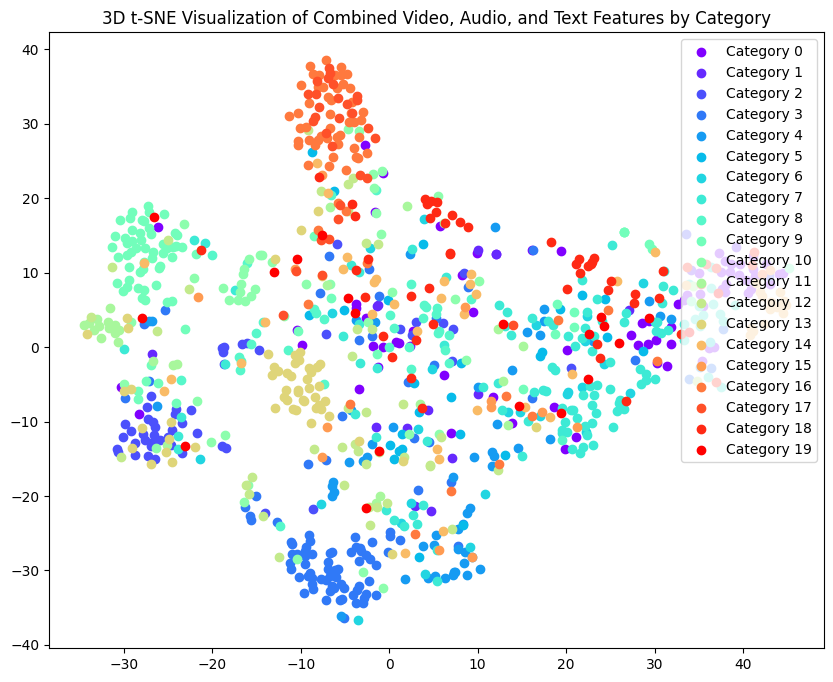

In [11]:
tsne = TSNE(n_components=2, random_state=42)
combined_features = np.concatenate([video_features, audio_features, text_features], axis=1)
tsne_results = tsne.fit_transform(combined_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

for i, category in enumerate(unique_categories):
    indices = categories == category
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], label=f'Category {category}')

plt.legend()
plt.title("3D t-SNE Visualization of Combined Video, Audio, and Text Features by Category")
plt.show()

In [6]:
video_features.shape, audio_features.shape, text_features.shape

((968, 20), (968, 20), (968, 20))

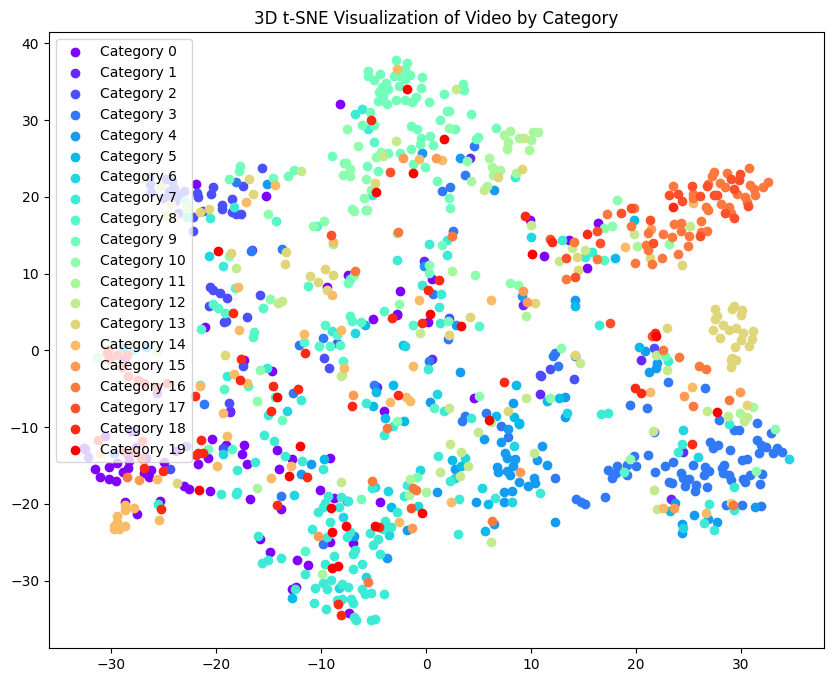

In [12]:
tsne_results = tsne.fit_transform(video_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

for i, category in enumerate(unique_categories):
    indices = categories == category
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], label=f'Category {category}')

plt.legend()
plt.title("3D t-SNE Visualization of Video by Category")
plt.show()

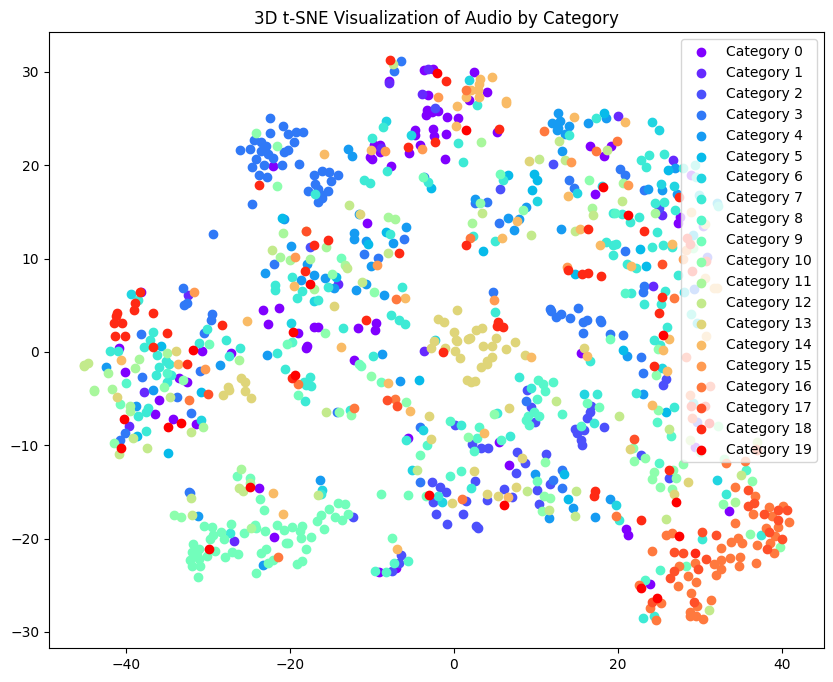

In [13]:
tsne_results = tsne.fit_transform(audio_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

for i, category in enumerate(unique_categories):
    indices = categories == category
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], label=f'Category {category}')

plt.legend()
plt.title("3D t-SNE Visualization of Audio by Category")
plt.show()

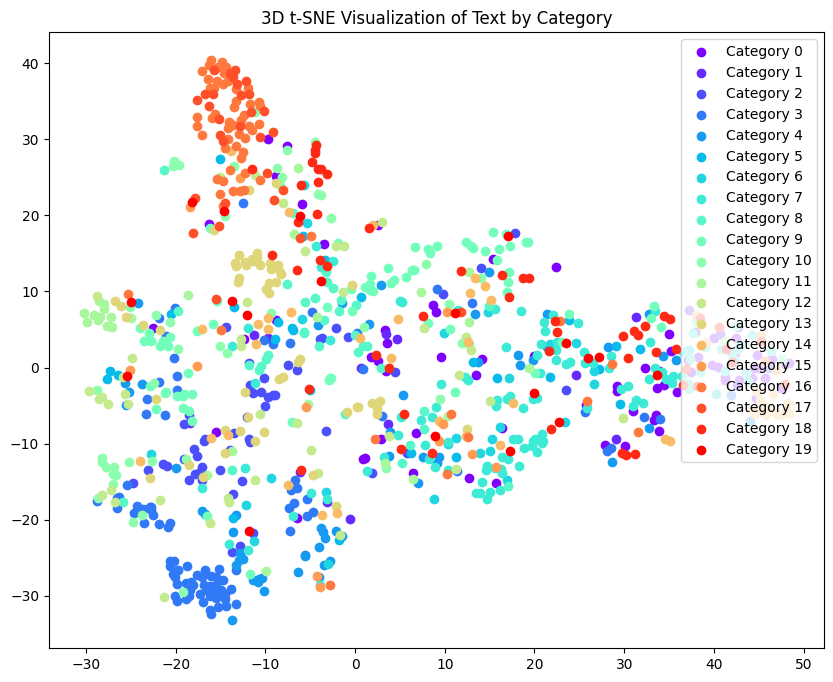

In [14]:
tsne_results = tsne.fit_transform(text_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

for i, category in enumerate(unique_categories):
    indices = categories == category
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], label=f'Category {category}')

plt.legend()
plt.title("3D t-SNE Visualization of Text by Category")
plt.show()